## В данном  блокноте будут рассмотрены различные способы обработки данных, получения эбедингов, среди которых: Bag 0f Words, TF-IDF, Word2Vec. А также  различные модели: NBC, SVM, RF, RNN и тд



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
import seaborn as sns
from sklearn.metrics import f1_score


In [2]:
import pandas as pd


df_train = pd.read_json("hf://datasets/AlexSham/Toxic_Russian_Comments/train.jsonl", lines=True)
df_test = pd.read_json("hf://datasets/AlexSham/Toxic_Russian_Comments/test.jsonl", lines=True)

X = df_train['text']
y = df_train['label']
X_test = df_test['text']
y_test = df_test['label']

In [3]:
X = [x.lower() for x in X]
X_test = [x.lower() for x in X_test]
maxLen = 0
for x in X:
  if len(x.split()) > maxLen:
    maxLen = len(x.split())
print(maxLen)
for x in X_test:
  if len(x.split()) > maxLen:
    maxLen = len(x.split())
print(maxLen)



262
267


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

## Bag of Words


In [5]:
count_vectorizer = CountVectorizer()
X_train_bof = count_vectorizer.fit_transform(X_train)
X_val_bof = count_vectorizer.transform(X_val)
X_test_bof = count_vectorizer.transform(X_test)



При помощи PCA, сократим размерность и откиним компоненты с наименьшей дисперсией, рассмотрев график распределения дисперсии каждой компоненты при начальном значении n_components = 1000

In [6]:
chi2_values, p_values = chi2(X_train_bof, y_train)

In [7]:
features = count_vectorizer.get_feature_names_out()
chi2_df = pd.DataFrame({
    'Feature': features,
    'Chi2': chi2_values,
    'p-value': p_values
})

chi2_df = chi2_df.sort_values(by='Chi2', ascending=False)


In [8]:
total_chi2 = chi2_df['Chi2'].sum()
chi2_df['Chi2_normalized'] = chi2_df['Chi2'] / total_chi2
chi2_df['Chi2_normalized_for_distribution'] = chi2_df['Chi2_normalized'].cumsum()

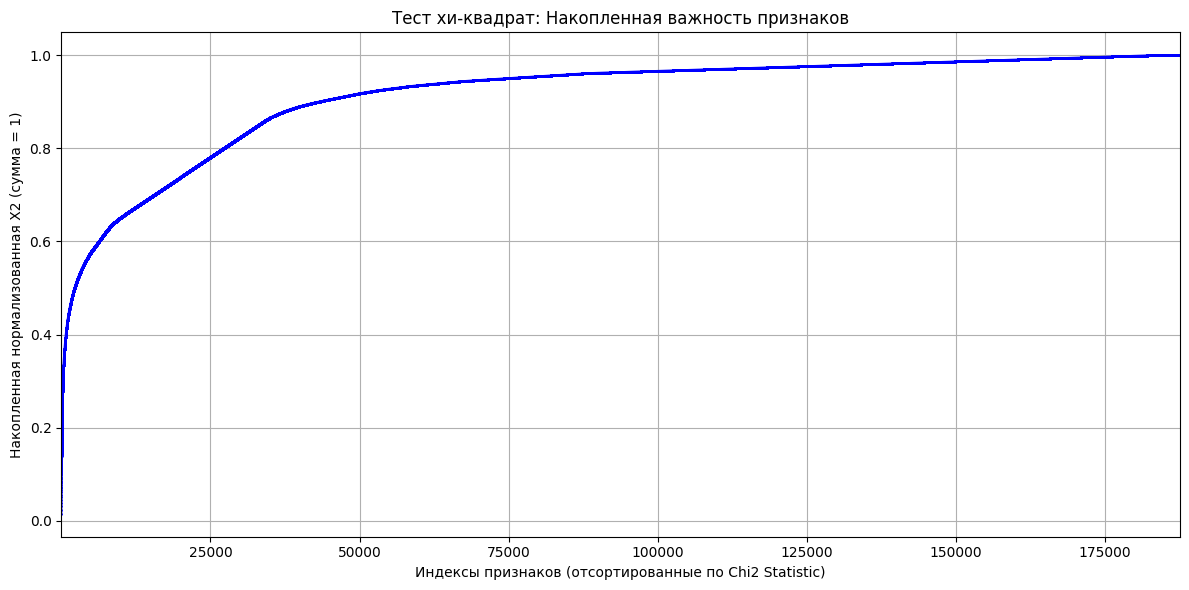

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(chi2_df['Chi2_normalized_for_distribution']) + 1),
        chi2_df['Chi2_normalized_for_distribution'], marker='o', color='blue', markersize=1)

plt.title('Тест хи-квадрат: Накопленная важность признаков')
plt.xlabel('Индексы признаков (отсортированные по Chi2 Statistic)')
plt.ylabel('Накопленная нормализованная X2 (сумма = 1)')
plt.xlim(1, len(chi2_df['Chi2_normalized_for_distribution']))
plt.grid()
plt.tight_layout()
plt.show()


График начинает выходить на асимптоту примерно на 75000

Попробуем другой вид графика, чтобы понять, что самые весомые слова действительно самые важные для классификации

C:\Users\nenad\AppData\Local\Temp\ipykernel_11296\2385409042.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Chi2', y='Feature', data=chi2_df.head(20), palette='viridis')


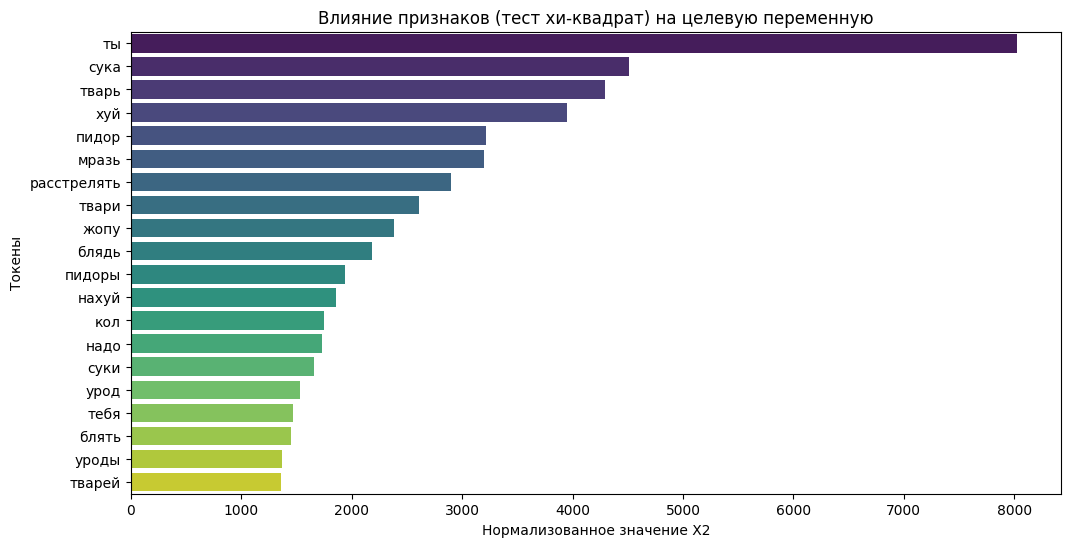

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Chi2', y='Feature', data=chi2_df.head(20), palette='viridis')
plt.title('Влияние признаков (тест хи-квадрат) на целевую переменную')
plt.xlabel('Нормализованное значение X2')
plt.ylabel('Токены')
plt.show()

Из этого графика интуитивно понятно, что X^2 значения действительно отражают действительность

## TF-IDF

In [11]:
tf_idf_vectorizer = TfidfVectorizer()
X_train_tfidf = tf_idf_vectorizer.fit_transform(X_train)
X_val_tfidf = tf_idf_vectorizer.transform(X_val)
X_test_tfidf = tf_idf_vectorizer.transform(X_test)

In [12]:
tokens = tf_idf_vectorizer.get_feature_names_out()
print("Отобранные токены:", tokens)

Отобранные токены: ['00' '000' '0000' ... '⁸9608894294' 'ℭßɛɱʌɑԋɑ' '檸檬爆弾']


In [13]:
print(X_train_tfidf[0])

  (0, 22553)	0.14610175009019816
  (0, 90257)	0.1491697281478167
  (0, 162050)	0.11944052998307145
  (0, 164577)	0.1173753521031062
  (0, 64493)	0.10923440423627614
  (0, 50401)	0.2623867602157904
  (0, 25365)	0.24848273249763425
  (0, 23089)	0.3407658298100749
  (0, 76714)	0.25646675171848016
  (0, 102065)	0.13941802496286482
  (0, 96309)	0.30483170548949834
  (0, 37298)	0.2462729581096699
  (0, 74126)	0.3883857943572326
  (0, 80063)	0.24539587761228931
  (0, 76354)	0.28843332618455103
  (0, 22530)	0.3380795373574553
  (0, 68584)	0.14958654013404113


##### можно пройтись PCA

## FastText unsupervised


In [14]:
import re

x_train_for_w2v = [re.findall(r'\b\w+\b', x) for x in X_train]

In [15]:
from gensim.models import Word2Vec
model_word2vec = Word2Vec(x_train_for_w2v,
                 vector_size=32,
                 min_count=5,
                 window=5
                ).wv

In [16]:
model_word2vec.most_similar("кот")

[('мальчик', 0.8878663182258606),
 ('собака', 0.8665534257888794),
 ('цветок', 0.8507512807846069),
 ('котенок', 0.841202437877655),
 ('дед', 0.8395481705665588),
 ('вид', 0.8382915258407593),
 ('знакомая', 0.8339545130729675),
 ('муж', 0.8330351114273071),
 ('потерялся', 0.8307427763938904),
 ('взгляд', 0.829743504524231)]

## LogisticRegrssion с оценкой влияния каждого токена



Попробуем обучить логистическую регрессию и оттуда уже оценить влияние каждого токена на таргет

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_bof, y_train)


LogisticRegression()

In [19]:
feature_importance = abs(log_reg_model.coef_)
feature_importance = feature_importance[0]
feature_importance

array([0.72000746, 0.12393781, 0.00204767, ..., 0.01698473, 0.00214492,
       0.00469092])

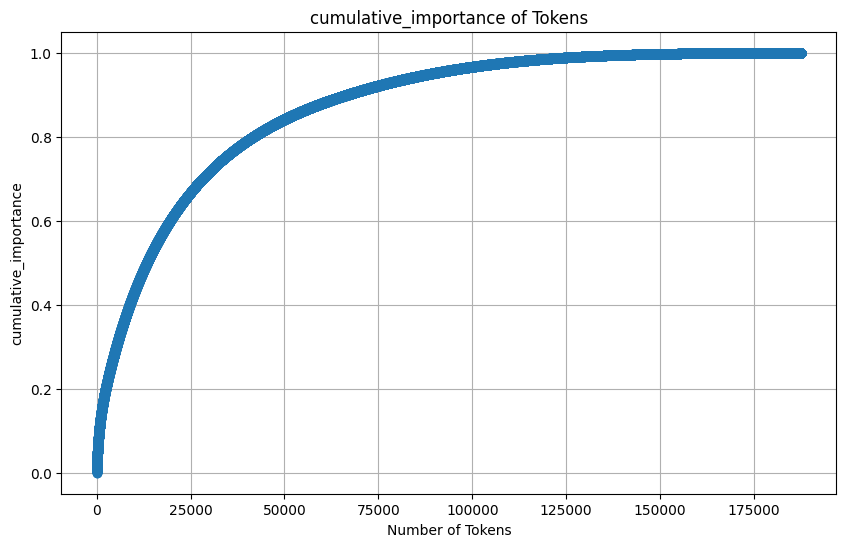

In [20]:
tokens = count_vectorizer.get_feature_names_out()
importance_df = pd.DataFrame({'token': tokens, 'importance': feature_importance})
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
importance_df['importance_normalized'] = importance_df['importance'] / importance_df['importance'].sum()
importance_df['cumulative_importance'] = importance_df['importance_normalized'].cumsum()
sorted_tokens = importance_df['token'].tolist()
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(importance_df) + 1), importance_df['cumulative_importance'], marker='o', linestyle='-')
plt.xlabel('Number of Tokens')
plt.ylabel('cumulative_importance')
plt.title('cumulative_importance of Tokens')
plt.grid()
plt.show()

На данном графике отчетливо видно, что брать больше 12500 не имеет смысла (по крайней мере на лог регрессии), так как график выходит на асимптоту


попоробуем несколько 10к признаков, 125000 и 175000 и сравним качество на валидациии и  поймем есть ли смысл брать большей фичей


In [21]:
from scipy.sparse import csr_matrix

# Индексируем разреженные матрицы
X_train_bof = csr_matrix(X_train_bof)
X_val_bof = csr_matrix(X_val_bof)
X_test_bof = csr_matrix(X_test_bof)

# Получаем числовые индексы для сортировки (если 'sorted_tokens' это список слов, то получаем их индексы)
token_index = {token: idx for idx, token in enumerate(sorted_tokens)}

# Теперь сортируем матрицу по индексу
X_train_bof = X_train_bof[:, [token_index[token] for token in sorted_tokens]]
X_val_bof = X_val_bof[:, [token_index[token] for token in sorted_tokens]]
X_test_bof = X_test_bof[:, [token_index[token] for token in sorted_tokens]]

# Проверка результата
print(X_train_bof.shape)


(156422, 187558)


In [22]:
num_of_features = {10000:'', # плохое количество фичей
                   75000: '', # оптимальное количество фичей с точки зрения X^2
                   125000:'', # оптимальное количество фичей с точки зрения LogReg
                   187558 :'' # все фичи
                   }
for f in num_of_features.keys():
  log_reg_model.fit(X_train_bof[:,:f], y_train)
  y_pred_val = log_reg_model.predict(X_val_bof[:,:f])
  num_of_features[f] = f1_score(y_val, y_pred_val)
maxY = 0
best_num_of_features = 0
for x, y in num_of_features.items():
  if maxY < y:
    best_num_of_features = x
  print("Количесвто фичей: ", x, "F1: ", y)
# Оценка лучшего результата на тесте
log_reg_model.fit(X_train_bof[:,:best_num_of_features], y_train)
y_pred_test = log_reg_model.predict(X_test_bof[:,:best_num_of_features])
F1_score = f1_score(y_test, y_pred_test)
print("Лучший результат на тестеа")
print('для ', best_num_of_features, ' фичей f1: ', F1_score)


C:\Users\nenad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Количесвто фичей:  10000 F1:  0.002953724975385625
Количесвто фичей:  75000 F1:  0.5744645525485639
Количесвто фичей:  125000 F1:  0.7418242710795903
Количесвто фичей:  187558 F1:  0.8689401087298378
Лучший результат на тестеа
для  187558  фичей f1:  0.8709559272372116


GridSearch для логистической регрессиии


In [23]:
from sklearn.metrics import classification_report
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Тип регуляризации
    'C': [0.01, 0.1, 1, 10, 100],  # Инверсия силы регуляризации
    'max_iter': [100, 500, 1000]  # Максимальное количество итераций
}

# Используем GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg_model,
    param_grid=param_grid,
    scoring='f1',  # Метрика для оптимизации
    cv=5,  # Количество фолдов для кросс-валидации
    verbose=2,
    n_jobs=-1  # Параллелизм
)

# Запуск обучения
grid_search.fit(X_train_bof, y_train)

# Лучшие параметры и оценка
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший F1-скор:", grid_search.best_score_)

# Оценка на валидационной выборке
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val_bof)
print("F1-скор на валидационной выборке:", f1_score(y_val, y_pred_val))

# Подробный отчет
print("Отчет классификации:\n", classification_report(y_val, y_pred_val))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\Users\nenad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nenad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nenad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\nenad\AppD

Лучшие параметры: {'C': 100, 'max_iter': 100, 'penalty': 'l2'}
Лучший F1-скор: 0.8847173588080484
F1-скор на валидационной выборке: 0.8920515806270756
Отчет классификации:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     54879
           1       0.94      0.85      0.89     12160

    accuracy                           0.96     67039
   macro avg       0.95      0.92      0.93     67039
weighted avg       0.96      0.96      0.96     67039



как оказалось, использование всех параметров сильно улучшает метрику и не сильно влияет на время обучение, так что оставляем все параметры

#TF-IDF на логрег

In [24]:
tf_idf_vectorizer = TfidfVectorizer(max_features = best_num_of_features)
X_train_tfidf = tf_idf_vectorizer.fit_transform(X_train)
X_val_tfidf = tf_idf_vectorizer.transform(X_val)
X_test_tfidf = tf_idf_vectorizer.transform(X_test)


In [25]:
log_reg_model.fit(X_train_tfidf, y_train)
y_pred_test = log_reg_model.predict(X_test_tfidf)
f1_score(y_test, y_pred_test)

0.8214606597355923

# word2vec на логрег


In [26]:
def text_df_to_w2v(df):
  df_for_w2v = []
  for x in df:
    curr_sentence = re.findall(r'\b\w+\b', x)
    curr_vec = np.zeros(32)
    for word in curr_sentence:
      if word in model_word2vec:
        curr_vec += model_word2vec[word]
    df_for_w2v.append(curr_vec)
  df_for_w2v = pd.DataFrame( df_for_w2v)
  return df_for_w2v
X_train_for_w2v = text_df_to_w2v(X_train)

In [27]:
X_train_for_w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,3.672341,6.419684,21.132740,15.799269,5.323146,2.691702,16.000123,27.997667,-9.166563,9.974690,...,31.124930,-7.708748,9.884007,-5.279710,-36.088427,-15.932296,4.748842,-3.111947,-10.767287,-1.154344
1,-2.203967,1.762788,7.492477,-0.830497,2.081489,-1.172505,8.400077,3.621036,-4.235809,-2.562923,...,5.168973,1.177227,-0.584465,-3.314575,-3.666350,1.240353,0.575924,-2.062550,-0.090063,0.863958
2,0.383679,-3.063956,2.843232,3.827477,-2.782445,1.421677,-2.418269,3.261425,-1.708909,0.147902,...,8.473796,2.702321,0.628667,0.444396,-1.241273,-2.374050,-3.591438,-1.071090,1.447155,0.509674
3,-8.710715,-0.648838,3.867827,-3.463365,-1.173472,-3.841366,7.284345,7.589458,-6.776811,7.195380,...,16.317540,-0.396947,3.441427,-5.076792,-18.976639,7.925216,-0.273741,8.847537,-9.719727,7.452148
4,8.928256,0.240656,5.897290,2.974902,5.580913,-1.243097,11.872644,7.625100,-12.058106,1.081793,...,1.524878,-4.461914,-3.880694,10.108105,-4.908346,0.844592,-6.745009,-7.045529,-0.060571,-7.662529


In [28]:

log_reg_model.fit(X_train_for_w2v, y_train)

LogisticRegression()

In [29]:
y_pred_test = log_reg_model.predict(text_df_to_w2v(X_test))
f1_score(y_test, y_pred_test)

0.5778413152251608

Как и ожидалось простое запихивании суммы векторов w2v предложения в лог рег не даст даст нужных результатов


# MNBC на CountVectorizer

In [30]:
from sklearn.naive_bayes import MultinomialNB

In [31]:
MNBC_clf = MultinomialNB()

In [32]:
num_of_features = {10000:'', # плохое количество фичей
                   75000: '', # оптимальное количество фичей с точки зрения X^2
                   125000:'', # оптимальное количество фичей с точки зрения LogReg
                   187558 :'' # все фичи
                   }
for f in num_of_features.keys():
  MNBC_clf.fit(X_train_bof[:,:f], y_train)
  y_pred_val = MNBC_clf.predict(X_val_bof[:,:f])
  num_of_features[f] = f1_score(y_val, y_pred_val)
maxY = 0
best_num_of_features = 0
for x, y in num_of_features.items():
  if maxY < y:
    maxY = y
    best_num_of_features = x
  print("Количесвто фичей: ", x, "F1: ", y)
# Оценка лучшего результата на тесте
MNBC_clf.fit(X_train_bof[:,:best_num_of_features], y_train)
y_pred_test = MNBC_clf.predict(X_test_bof[:,:best_num_of_features])
F1_score = f1_score(y_test, y_pred_test)
print("Лучший результат на тестеа")
print('для ', best_num_of_features, ' фичей f1: ', F1_score)


Количесвто фичей:  10000 F1:  0.012351698358524297
Количесвто фичей:  75000 F1:  0.5872294372294372
Количесвто фичей:  125000 F1:  0.7546119367775419
Количесвто фичей:  187558 F1:  0.859736953754773
Лучший результат на тестеа
для  187558  фичей f1:  0.8627723690310617


In [33]:
alphas = np.arange(0.1, 2, 0.15)
best_alpha = 0
best_f1 = 0
for a in alphas:
  MNBC_clf = MultinomialNB(alpha = a)
  MNBC_clf.fit(X_train_bof[:,:best_num_of_features], y_train)
  y_pred_val = MNBC_clf.predict(X_val_bof[:,:best_num_of_features],)
  F1 = f1_score(y_val, y_pred_val)
  print('alpha: ', a, 'f1: ', F1)
  if F1 > best_f1:
    best_f1 = F1
    best_alpha = a

print('=============')
MNBC_clf = MultinomialNB(alpha = best_alpha)
MNBC_clf.fit(X_train_bof[:,:best_num_of_features], y_train)
y_pred_test = MNBC_clf.predict(X_test_bof[:,:best_num_of_features])
F1_score = f1_score(y_test, y_pred_test)
print('Итог: ', F1_score, "для alpha = ", best_alpha)

alpha:  0.1 f1:  0.8404842169782408
alpha:  0.25 f1:  0.8513497766556613
alpha:  0.4 f1:  0.8585207732142152
alpha:  0.5499999999999999 f1:  0.8629855201064817
alpha:  0.7 f1:  0.8637819196978406
alpha:  0.85 f1:  0.863103433888263
alpha:  0.9999999999999999 f1:  0.859736953754773
alpha:  1.1500000000000001 f1:  0.8563176272793895
alpha:  1.3 f1:  0.8506973287281948
alpha:  1.45 f1:  0.8447970218046446
alpha:  1.6 f1:  0.8378220403758824
alpha:  1.75 f1:  0.8315209973156195
alpha:  1.9 f1:  0.8235619214295583
Итог:  0.8666368315059297 для alpha =  0.7


# MNBC на TFIDF

In [34]:
# Зададим параметры для перебора
param_grid = {
    'max_features': [10000, 75000, 125000, 187558],  # Число признаков
    'min_df': [1, 2, 5],  # Минимальная частота слов в документах
    'max_df': [0.7, 0.85, 1.0],  # Максимальная доля документов, в которых слово встречается
    'sublinear_tf': [True],  # Используем sublinear_tf
    'ngram_range': [(1, 1), (1, 2)]  # Биграммы и униграммы
}

# Инициализация TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Преобразуем данные в виде пайплайна
X_train_raw = X_train  # Оригинальные тексты
pipeline = GridSearchCV(
    estimator=tfidf_vectorizer,
    param_grid=param_grid,
    scoring='f1',
    cv=3,  # Кросс-валидация
    verbose=2,
    n_jobs=-1
)

# Подбор гиперпараметров
pipeline.fit(X_train_raw, y_train)
best_params = pipeline.best_params_

# Выводим лучшие параметры
print("Лучшие параметры TF-IDF:", best_params)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\nenad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Лучшие параметры TF-IDF: {'max_df': 0.7, 'max_features': 10000, 'min_df': 1, 'ngram_range': (1, 1), 'sublinear_tf': True}


In [35]:
# Используем лучшие параметры для преобразования данных
tfidf_vectorizer = TfidfVectorizer(
    max_features=best_params['max_features'],
    min_df=best_params['min_df'],
    max_df=best_params['max_df'],
    sublinear_tf=best_params['sublinear_tf'],
    ngram_range=best_params['ngram_range']
)

# Преобразуем данные
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Обучение MNBC
mnbc_clf = MultinomialNB()
mnbc_clf.fit(X_train_tfidf, y_train)

# Оценка модели на тесте
y_pred_test = mnbc_clf.predict(X_test_tfidf)
f1 = f1_score(y_test, y_pred_test)
print("F1-Score на тесте:", f1)


F1-Score на тесте: 0.8228266395526183


модель генеративная (в том смысле, что работает с вероятностями), поэтому веса в tf-idf ей только мешают

# SVM на CountVectorizer

In [36]:
from scipy.sparse import vstack

In [37]:
X_grid_bow = vstack([X_train_bof[:,:best_num_of_features], X_val_bof[:,:best_num_of_features]])
y_grid = np.concatenate([y_train, y_val])

In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'max_iter': [1000, 3000, 5000]

}
linear_svc = LinearSVC(random_state=42, max_iter=10000)
grid_search_bow = GridSearchCV(linear_svc, param_grid, scoring='f1', cv=3)
grid_search_bow.fit(X_grid_bow, y_grid)




C:\Users\nenad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nenad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nenad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nenad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of 

GridSearchCV(cv=3, estimator=LinearSVC(max_iter=10000, random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [1000, 3000, 5000], 'penalty': ['l2']},
             scoring='f1')

In [39]:
# Оценка модели на тест выборке
best_svc_bow = grid_search_bow.best_estimator_
y_pred_bow = best_svc_bow.predict(X_test_bof[:,:best_num_of_features])
f1_bow = f1_score(y_test, y_pred_bow)

print(f"Лучший F1-score на тестовой выборке (Bag of Words): {f1_bow}")
print(f"Лучший параметр C (Bag of Words): {grid_search_bow.best_params_['C']}")

Лучший F1-score на тестовой выборке (Bag of Words): 0.9080553295362083
Лучший параметр C (Bag of Words): 1


In [40]:
print(grid_search_bow.best_params_)

{'C': 1, 'max_iter': 1000, 'penalty': 'l2'}


# SVM на TF-IDF


In [41]:
X_grid_tfidf = vstack([X_train_tfidf, X_val_tfidf])

In [42]:
linear_svc = LinearSVC(random_state=42, max_iter=10000)

# Подбор гиперпараметра C с помощью GridSearchCV для TF-IDF
grid_search_tfidf = GridSearchCV(linear_svc, param_grid, scoring='f1', cv=3)
grid_search_tfidf.fit(X_grid_tfidf, y_grid)


C:\Users\nenad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nenad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nenad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nenad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of 

GridSearchCV(cv=3, estimator=LinearSVC(max_iter=10000, random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [1000, 3000, 5000], 'penalty': ['l2']},
             scoring='f1')

In [43]:
best_svc_tfidf = grid_search_tfidf.best_estimator_
y_pred_tfidf = best_svc_tfidf.predict(X_test_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf)

print(f"Лучший F1-score на валидационной выборке (TF-IDF): {f1_tfidf}")
print(f"Лучший параметр C (TF-IDF): {grid_search_tfidf.best_params_['C']}")

Лучший F1-score на валидационной выборке (TF-IDF): 0.8716577540106952
Лучший параметр C (TF-IDF): 1
